<a href="https://colab.research.google.com/github/Quanxibanyang/cosmopower/blob/main/tf_planck2018_lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

| | |
| --- | --- |
| **Author** | Alessio Spurio Mancini |
| **email** | a.spuriomancini@ucl.ac.uk |

<div align="center"><img src='https://drive.google.com/uc?id=1KTafFIJzWQTBdtdd6xrI7OszfhpZYkVM' width="400" height="300"></div>

In this notebook we will see an example of how to run a complete inference pipeline with power spectra sourced from ``CosmoPower``. We will run a version of the _Planck_ 2018 ``lite`` likelihood, rewritten to be fully implemented in [TensorFlow](https://www.tensorflow.org/): ``tf_planck2018_lite``. The ``lite`` version of the _Planck_ likelihood is pre-marginalised over a set of nuisance parameters. The TensorFlow version of this likelihood, provided as part of ``CosmoPower``, is an adaptation for TensorFlow of the [planck-lite-py](https://github.com/heatherprince/planck-lite-py) likelihood written by H. Prince and J. Dunkley.

If you use ``tf_planck2018_lite``, _in addition_ to the ``CosmoPower`` [release paper](https://arxiv.org/abs/2106.03846) please also cite [Prince & Dunkley (2019)](https://arxiv.org/abs/1909.05869) and [Planck (2018)](https://arxiv.org/abs/1907.12875).

In [60]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import trange

In [61]:
# checking that we are using a GPU
device = 'gpu:0' if tf.test.is_gpu_available() else 'cpu'
print('using', device, 'device \n')

using gpu:0 device 



# TENSORFLOW AFFINE SAMPLER

Since we have a likelihood that is purely implemented in TensorFlow, to take maximum advantage of the speed-up provided by this library we can run the inference using a sampler _also_ fully implemented in TensorFlow, so that the whole inference process can be run on a Graphics Processing Units. For example, we can install the affine sampler from [this repository](https://github.com/justinalsing/affine):

In [62]:
!pip install git+https://github.com/justinalsing/affine.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/justinalsing/affine.git to /tmp/pip-req-build-vjq0xr38
  Running command git clone -q https://github.com/justinalsing/affine.git /tmp/pip-req-build-vjq0xr38


In [63]:
import affine

# TF_PLANCK2018_LITE

First we need to instantiate the emulators for the TT, TE, EE power spectra. These are required by the ``tf_planck2018_lite`` likelihood. In this example we will use the pre-trained model of the ``CosmoPower`` [release paper](https://arxiv.org/abs/2106.03846), available [in the ``CosmoPower`` repository](https://github.com/alessiospuriomancini/cosmopower/blob/main/cosmopower/trained_models/CP_paper/CMB).

In [64]:
!git clone https://github.com/sophuang/cosmopower.git

fatal: destination path 'cosmopower' already exists and is not an empty directory.


In [65]:
!pip install /content/cosmopower

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./cosmopower
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for cosmopower: filename=cosmopower-0.1.0-py3-none-any.whl size=39761 sha256=4682416b02b0a59993af0958b8ef0b8d97c5680ddddbc56114d5385f6082f1f0
  Stored in directory: /tmp/pip-ephem-wheel-cache-x293oa9y/wheels/4f/fb/ec/bd67e3129fac4d879236cc05496849b66f428cf63074c0e7de
Successfully built cosmopower
  Attempting uninstall: cosmopower
    Found existing installation: cosmopower 0.1.0
    Uninstalling cosmopower-0.1.0:
      Successfully uninstalled cosmopower-0.1.0

In [66]:
import cosmopower as cp

tt_emu_model = cp.cosmopower_NN(restore=True,
                                restore_filename='/content/cosmopower/cosmopower/trained_models/CP_paper/CMB/cmb_TT_NN'
                               )

te_emu_model = cp.cosmopower_PCAplusNN(restore=True,
                                restore_filename='/content/cosmopower/cosmopower/trained_models/CP_paper/CMB/cmb_TE_PCAplusNN'
                               )

ee_emu_model = cp.cosmopower_NN(restore=True,
                                restore_filename='/content/cosmopower/cosmopower/trained_models/CP_paper/CMB/cmb_EE_NN'
                               )

Now let's create an instance of the pure-TensorFlow version of the Planck 2018 lite likelihood, ``tf_planck2018_lite``. It requires:

- a path to the ``tf_planck2018_lite`` likelihood. It will be used to access the _Planck_ data;

- parameters of the analysis, as well as their priors;

- the ``CosmoPower`` emulators.

In [78]:
# path to the tf_planck2018_lite likelihood
tf_planck2018_lite_path = '/content/cosmopower/cosmopower/likelihoods/tf_planck2018_lite/'

# parameters of the analysis, and their priors
parameters_and_priors = {'omega_b':      [0.001, 0.04, 'uniform'],
                         'omega_cdm':    [0.005, 0.99,  'uniform'],
                         'h':            [0.2,   1.0,   'uniform'],
                         'tau_reio':     [0.01,  0.8,   'uniform'],
                         'n_s':          [0.9,   1.1,   'uniform'],
                         'ln10^{10}A_s': [1.61,  3.91,  'uniform'],
                         'A_planck':     [1.0,   0.01,  'gaussian'],
                          }

# instantiation
tf_planck = cp.tf_planck2018_lite(parameters=parameters_and_priors, 
                                  tf_planck2018_lite_path=tf_planck2018_lite_path,
                                  tt_emu_model=tt_emu_model,
                                  te_emu_model=te_emu_model,
                                  ee_emu_model=ee_emu_model
                                  )
tf_planck_pos = cp.tf_planck2018_lite_posterior(parameters=parameters_and_priors, 
                                  tf_planck2018_lite_path=tf_planck2018_lite_path,
                                  tt_emu_model=tt_emu_model,
                                  te_emu_model=te_emu_model,
                                  ee_emu_model=ee_emu_model
                                  )

# initial points
FIDUCIAL = np.reshape(np.array([ 0.022242,  0.11977,  0.673,  0.055,  0.9658,  3.0753,  1.0080]).astype('float32'), (1, 7))
EPSILON  = np.reshape(np.array([ 1E-4,      1E-4,     1E-2,   1E-3,   1E-3,    1E-3,    1E-4]).astype('float32'), (1,7))


We will also define a fiducial point in parameter space and the radii of the balls used to initialize the walkers for sampling.

In [68]:
# initial points
FIDUCIAL = np.reshape(np.array([ 0.022242,  0.11977,  0.673,  0.055,  0.9658,  3.0753,  1.0080]).astype('float32'), (1, 7))
EPSILON  = np.reshape(np.array([ 1E-4,      1E-4,     1E-2,   1E-3,   1E-3,    1E-3,    1E-4]).astype('float32'), (1,7))

### Target log probability

Takes tensor of (n_walkers, n_parameters) input parameter vectors, return shape (n_walkers,) i.e., the log probability for each of the input parameter vectors. This is the main output produced by ``tf_planck2018_lite`` (cf. its method ``posterior``).

In [82]:
@tf.function
def log_prob(theta):
    return tf.squeeze(tf_planck.posterior(theta), -1)
def log_prob_pos(theta):
    return tf.squeeze(tf_planck_pos.posterior(theta), -1)

### Initialize the walkers
You need to initialize *two* sets of "walkers", each of shape (n_walkers, n_parameters), for the parallel affine sampler. It's generally a good idea to initialize walkers in a tight-ish ball close to some fiducial parameter guess (and the sampler will burn in from there). The two sets of walkers (put into a list) define the initial "current state" for the sampler.

In [80]:
# number of parameters
n_params = len(parameters_and_priors)

# number of walkers (note you'll end up with a total of 2*n_walkers for this parallel variant of the affine sampler)
n_walkers = 500

# initialize walkers and current state
walkers1 = tf.random.normal([n_walkers, n_params], FIDUCIAL, EPSILON)
walkers2 = tf.random.normal([n_walkers, n_params], FIDUCIAL, EPSILON)
current_state = [walkers1, walkers2]

### Run the sampler!

In [83]:
# number of MCMC steps to take (you'll end up with an MCMC chain with shape (n_steps, 2*n_walkers, n_parameters))
n_steps = 300

# run the sampler
with tf.device(device):
    chain = affine.affine_sample(log_prob, n_steps, current_state, args=[])
with tf.device(device):
    chain_pos = affine.affine_sample(log_prob_pos, n_steps, current_state, args=[])

100%|██████████| 299/299 [00:04<00:00, 62.07it/s]


(500, None)
()
(500, None)
(1, 613)
()
(613, 613)
(500, 500)
(500,)


ValueError: ignored

### Plot the results

In [72]:
# plot the results...

# how many burnin steps to remove
burnin_steps = 100
samples = chain.numpy()[burnin_steps:,:,:].reshape((-1, n_params))

In [73]:
!pip install getdist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [74]:
from getdist import plots, MCSamples
names = [r"\omega_{\mathrm{b}}", 
         r"\omega_{\mathrm{cdm}}", 
         r"h", 
         r"\tau",
         r"n_s", 
         r"ln 10^{10} A_s", 
         r"A_{\mathrm{Planck}}"]
labels = names
mcsamples = MCSamples(samples=samples,names = names, labels = labels)
g = plots.get_subplot_plotter()
g.settings.axes_fontsize = 18
g.settings.lab_fontsize = 30
g.settings.legend_fontsize = 50

Removed no burn in


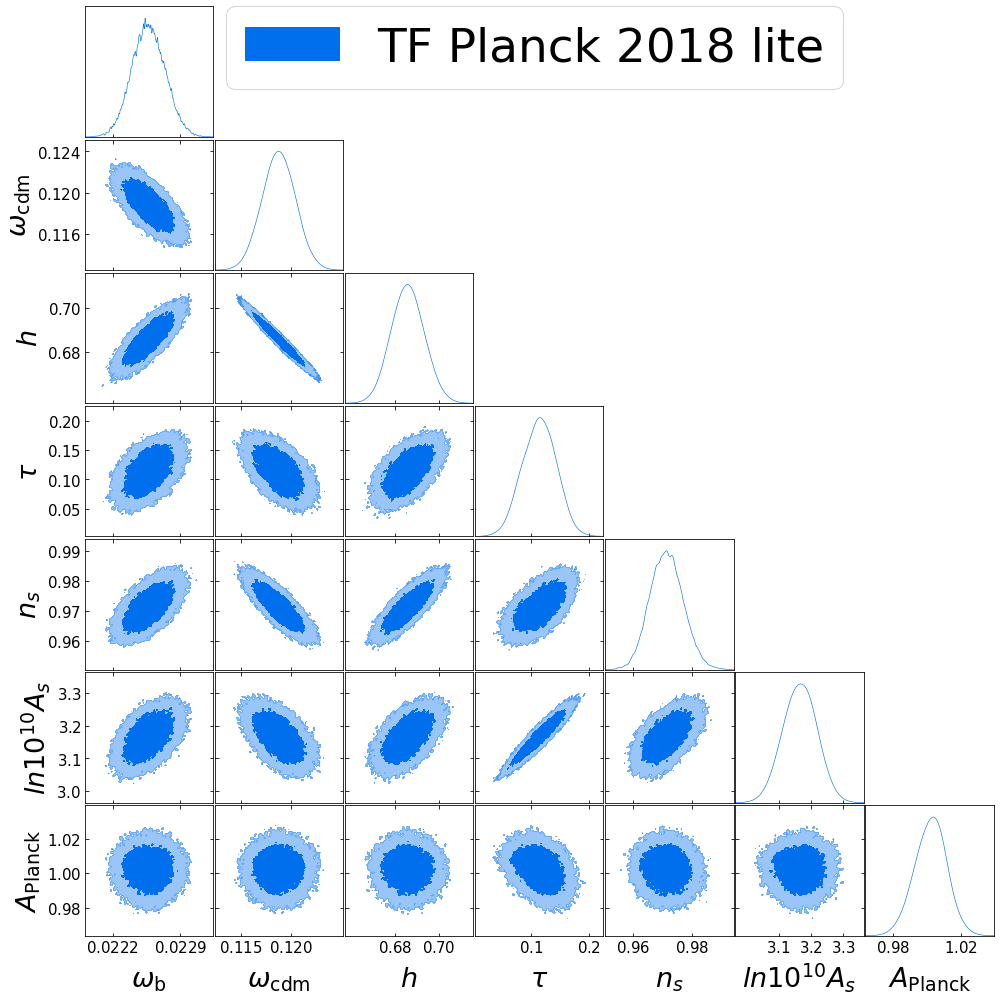

In [75]:
g.triangle_plot([mcsamples], filled=True, legend_labels=['TF Planck 2018 lite'])